<a href="https://colab.research.google.com/github/enzoephrem/TumorSeg/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
# Required to install medpy package
!pip install medpy

In [ ]:
import os
import numpy as np
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Cursor
import skimage.io as io
from math import ceil

## Import your data

Upload kaggle.json to your Colab project: for instance, you can import `files` module from `google.colab`, and call `upload()` to launch a File Upload dialog and select the kaggle.json from your local machine.

In [ ]:
from google.colab import files
API_key = files.upload()

Saving kaggle.json to kaggle.json


Update `KAGGLE_CONFIG_DIR` path to the current working directory. You can run `!pwd` to get the current working directory and assign the value to `os.environ['KAGGLE_CONFIG_DIR']` :

In [ ]:
!pwd

/content


In [ ]:
import os
current_dir = os.popen('pwd').read().strip()
os.environ['KAGGLE_CONFIG_DIR'] = current_dir

In [ ]:
# Download dataset

#!chmod 600 /content/kaggle.json # uncomment to set API key to unreadable
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

100% 4.16G/4.16G [00:31<00:00, 155MB/s]
100% 4.16G/4.16G [00:31<00:00, 141MB/s]


In [ ]:
# Unizp imported dateset
!unzip brats20-dataset-training-validation.zip &> /dev/null # &> /dev/null to not prompt the output

In [ ]:
# Rename a specific file with a typo in the 355 patient folder (TrainingData, patient 355, segmentation file)
os.rename("/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii",
          "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii")

## **Loading/Visualizing our data**

#### To begin with let's get familiar with the data we are working with :

* The features (inputs)

    *  Brain scans (IRMs) are generally made of 4 sequences (Flair, T1, T1CE, T2).
        - **Flair** : Fluid Attenuated Inversion Recovery
        - **T1** : bla
        - **T1CE** : bla
        - **T2** : bla
    * Each chanel being a 3D image (X, Y, Z). A 3D image of a brain is commonly called a voxel.

* The labels (outputs)

    * 3D images called masks, that represents the tumor in a brain.
    * The integer values in this array indicate the "classified label" for each voxel in the corresponding image files:

        - 0: background
        - 1: edema
        - 2: non-enhancing tumor
        - 3: N/A
        - 4: enhancing tumor
    * Replace label 4 by 3 because 3 by default is empty in the processing step.

#### Loading an image into an array

In [ ]:
def loadImage(filename=None):
	"""
	Load a brain IRM or npy array 
	"""

	if filename == None:
		print("Make sure to enter an image filename")
		return -1

	# Load inputs data
	if filename.split('.')[-1] == 'mha':
		print("Input file: mha")
		image_data, image_header = medpy.io.load(filename)
	elif filename.split('.')[-1] == 'nii' or 'nii' + filename.split('.')[-1] == 'niigz':
		print("Input file: nii")
		image_data = nib.load(filename).get_fdata()
	elif filename.split('.')[-1] == 'npy':
		print("Input file: numpy array")
		image_data = np.load("filename")
	else:
		print("Make sure to enter a supported file extension (.mha / .nii / .nii.gz)")
		return -1

	print("File information:")
	print("Shape: {}".format(image_data.shape))
 
	return image_data

#### Simple 2D plotting

In [ ]:
def display2D(image_filename=None, seg_filename=None, image_color_map='bone', seg_color_map='jet', seg_alpha=0.5):
    """
    Displays random cut random layer for a given 1 sequence voxel
    """

    image_data = loadImage(image_filename)
    if len(image_data) < 0:
        # Return value of loadign image < 0 -> error occurred
        return -1

    if seg_filename:
        seg_data = loadImage(seg_filename)
        if image_data.shape != seg_data.shape:
            print("Image data and Segmentation data do not have the same shape {}!={}".format(image_data.shape, seg_data.shape))
            return -1
        if len(seg_data) < 0:
            return -1
        
        fig, ax = plt.subplots(1, 2)
        
    
    cut = random.randint(0, 2)

    if cut == 0:
        index = random.randint(0, image_data.shape[cut])
        if seg_filename:
            ax[0].set_title("YZ cut | layer: {}".format(index))
            ax[1].set_title("Segmentation/Mask")
            ax[0].imshow(image_data[index, :, :], cmap=image_color_map)
            ax[1].imshow(seg_data[index, :, :], cmap=seg_color_map)
        else:
            plt.title("YZ cut | layer: {}".format(index))
            plt.imshow(image_data[index, :, :], cmap=image_color_map)

    elif cut == 1:
        index = random.randint(0, image_data.shape[cut])
        if seg_filename:
            ax[0].set_title("XZ cut | layer: {}".format(index))
            ax[1].set_title("Segmentation/Mask")
            ax[0].imshow(image_data[:, index, :], cmap=image_color_map)
            ax[1].imshow(seg_data[:, index, :], cmap=seg_color_map)
        else:
            plt.title("XZ cut | layer: {}".format(index))
            plt.imshow(image_data[:, index, :], cmap=image_color_map)

    elif cut == 2:
        index = random.randint(0, image_data.shape[cut])
        if seg_filename:
            ax[0].set_title("XY cut | layer: {}".format(index))
            ax[1].set_title("Segmentation/Mask")
            ax[0].imshow(image_data[:, :, index], cmap=image_color_map)
            ax[1].imshow(seg_data[:, :, index], cmap=seg_color_map)
        else:
            plt.title("XY cut | layer: {}".format(index))
            plt.imshow(image_data[:, :, index], cmap=image_color_map)
    else:
        print("Something went wrong")
    

Input file: nii
File information:
Shape: (240, 240, 155)
Input file: nii
File information:
Shape: (240, 240, 155)


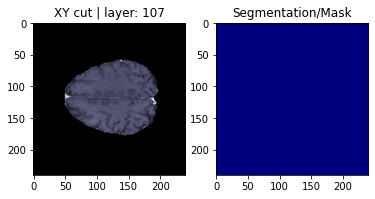

In [ ]:
PATIENT = "002"
SEQUENCE = "t1ce"
image_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{}/BraTS20_Training_{}_{}.nii".format(PATIENT, PATIENT, SEQUENCE)
seg_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{}/BraTS20_Training_{}_seg.nii".format(PATIENT, PATIENT)
display2D(image_path, seg_path)

### Full 3D IRM display of a brain

To get a better overall view of the brain we should implement a function that gives us the posibility to look at every slice of the brain from any cut (angle) given.

In medical terms:
* Horizontal Cut (XY)
* Coronal Cut (XZ)
* Sagittal Cut (YZ)

>  **⚠️ Input shape should be (X, Y, Z)** (chose between flair, t1, t1ce and t2 for image_filename, and segmentation (seg) for seg_filename)

To be implemented -> interactive choice of chanel



In [ ]:
# Display IRM

def display3DCuts(image_filename=None, seg_filename=None, image_color_map='bone', seg_color_map='jet', seg_alpha=0.5):


	# Loading image files

    image_data = loadImage(image_filename)
    if len(image_data) < 0:
        # Return value of loadign image < 0 -> error occurred
        return -1

    if seg_filename:
        seg_data = loadImage(seg_filename)
        if image_data.shape != seg_data.shape:
            print("Image data and Segmentation data do not have the same shape {}!={}".format(image_data.shape, seg_data.shape))
            return -1
        if len(seg_data) < 0:
            return -1

    # Plot with 3 Columns
    fig, ax = plt.subplots(1, 3)
    plt.subplots_adjust(bottom=0.25)

    # Create layers to place widgets
    axlayer_X = plt.axes([0.25, 0.2, 0.30, 0.03])
    axlayer_Y = plt.axes([0.25, 0.15, 0.30, 0.03])
    axlayer_Z = plt.axes([0.25, 0.1, 0.30, 0.03])

    # Get aprox the middle images for each of X Y Z
    half_X = ceil((image_data.shape[0] - 1)/2)
    half_Y = ceil((image_data.shape[1] - 1)/2)
    half_Z = ceil((image_data.shape[2] - 1)/2)

    # Create Slider for each cut
    slider_X = Slider(axlayer_X, "Sagittal Cut", 0, image_data.shape[0] - 1, valinit=half_X, valstep=1)
    slider_Y = Slider(axlayer_Y, "Coronal Cut", 0, image_data.shape[1] - 1, valinit=half_Y, valstep=1)
    slider_Z = Slider(axlayer_Z, "Horizontal Cut", 0, image_data.shape[2] - 1, valinit=half_Z, valstep=1)

    # Set title for each ax
    ax[0].set_title("{}/{}".format(half_X, image_data.shape[0] - 1))
    ax[1].set_title("{}/{}".format(half_Y, image_data.shape[1] - 1))
    ax[2].set_title("{}/{}".format(half_Z, image_data.shape[2] - 1))

    # Update function for each respective slider and it's plot
    def update_X(val):
        layer = slider_X.val
        ax[0].imshow(image_data[layer,:,:], cmap=image_color_map)
        if seg_filename:
            ax[0].imshow(seg_data[layer,:,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[layer,:,:]>0))
        ax[0].set_title("{}/{}".format(layer, image_data.shape[0] - 1))
        fig.canvas.draw_idle()

    def update_Y(val):
        layer = slider_Y.val
        ax[1].imshow(image_data[:,layer,:], cmap=image_color_map)
        if seg_filename:
            ax[1].imshow(seg_data[:,layer,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,layer,:]>0))
        ax[1].set_title("{}/{}".format(layer, image_data.shape[1] - 1))
        fig.canvas.draw_idle()

    def update_Z(val):
        layer = slider_Z.val
        ax[2].imshow(image_data[:,:,layer], cmap=image_color_map)
        if seg_filename:
            ax[2].imshow(seg_data[:,:,layer], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,:,layer]>0))
        ax[2].set_title("{}/{}".format(layer, image_data.shape[2] - 1))
        fig.canvas.draw_idle()

    # Update plot when detected interaction with slider
    slider_X.on_changed(update_X)
    slider_Y.on_changed(update_Y)
    slider_Z.on_changed(update_Z)

    # First display
    ax[0].imshow(image_data[half_X,:,:], cmap=image_color_map)
    ax[1].imshow(image_data[:,half_Y,:], cmap=image_color_map)
    ax[2].imshow(image_data[:,:,half_Z], cmap=image_color_map)
    if seg_filename:
        ax[0].imshow(seg_data[half_X,:,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[half_X,:,:]>0))
        ax[1].imshow(seg_data[:,half_Y,:], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,half_Y,:]>0))
        ax[2].imshow(seg_data[:,:,half_Z], cmap=seg_color_map, alpha=seg_alpha*(seg_data[:,:,half_Z]>0))

    # Turn off all of the axis
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')

    # Show plot
    plt.show()


Input file: nii
File information:
Shape: (240, 240, 155)
Input file: nii
File information:
Shape: (240, 240, 155)


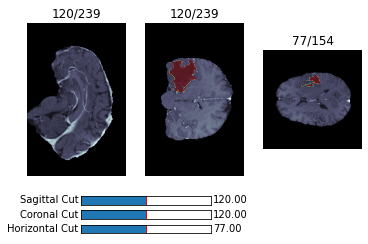

In [ ]:
display3DCuts(image_path, seg_path) # Due to colab not being interactive with matplotlib interactive ploting not working for the moment

## Data processing

* Rescale the data we are working with

* Lots of infromation are not helpful and can lead to biases in our neural networks.

    * The data given contains 4 sequence as mentionned above. Knowing that the T1ce is a contrast-enhanced version of the T1 we can get rid of the T1 sequence.
    * Empty (black) portions of the scans : reduce the shape of the data from 255x255x155 to 128x128x128 to "crop" the images taking out all the blanc usless information (less computing time + less bias for the Neural Network).

* Input shape of the model
    * S being the number of sequences: (X, Y, Z, S) -> (128, 128, 128, 3)

* Output shape of the model
    * (X, Y, Z) -> (128, 128, 128) 

In [ ]:
from tensorflow.keras.utils import to_categorical
import glob
from sklearn.preprocessing import MinMaxScaler

# Init a MinMaxScaler
scaler = MinMaxScaler()

### Process feature images (Brain)

Four step process:
* Scale each eequence array
* Combine 3 of the 4 sequence given (Flair, T1CE and T2) into one array
* Reshape/Crop it 
* Save it as a numpy array (`.npy`)

Getting a final result of a (128, 128, 128, 3) array  

In [ ]:
def process_images(patient_dir_path, processed_path=""):
    """
    Stacking three 1 chanel IRMs into one 3 chanel IRM and scaling each image values from 0 to 1
    Then croping it to 128x128x128 images.
    Saving it as a numpy array .npy
    """

    patient = patient_dir_path.split('/')[-1]

    image_flair = nib.load(os.path.join(patient_dir_path, "{}_flair.nii".format(patient))).get_fdata()
    image_flair = scaler.fit_transform(image_flair.reshape(-1, image_flair.shape[-1])).reshape(image_flair.shape)

    """
    # The data extracted from t1 chanels are not useful
    test_image_t1 = nib.load(os.path.join(patient_dir_path, "{}/{}_t1.nii".format(patient, patient))).get_fdata()
    test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)
    """

    image_t1ce = nib.load(os.path.join(patient_dir_path, "{}_t1ce.nii".format(patient))).get_fdata()
    image_t1ce = scaler.fit_transform(image_t1ce.reshape(-1, image_t1ce.shape[-1])).reshape(image_t1ce.shape)

    image_t2 = nib.load(os.path.join(patient_dir_path, "{}_t2.nii".format(patient))).get_fdata()
    image_t2 = scaler.fit_transform(image_t2.reshape(-1, image_t2.shape[-1])).reshape(image_t2.shape)

    # Stack 3 most important channel into 1 numpy array to feed the U-Net
    resulting_image = np.stack([image_flair,
            image_t1ce,
            image_t2], axis=3)

    # Crop the image to 128x128x128
    resulting_image = resulting_image[56:184, 56:184, 13:141] # Shape 128x128x128x3 (x4 if t1 included)

    np.save(os.path.join(processed_path, "image", patient+".npy"), resulting_image)

### Process label images (Mask)

In [ ]:
def process_mask(patient_dir_path, processed_path=""):
    """ 
    Mask relabeling 4 -> 3 (label 3 is empty)
    Then croping it to 128x128x128 images, taking out all the blanc usless information (less computing time + less bias for the Neural Network)
    Ratio thing usless for now then Saving it as a numpy array .npy
    """

    patient = patient_dir_path.split('/')[-1]

    mask = nib.load(os.path.join(patient_dir_path, "{}_seg.nii".format(patient))).get_fdata()
    mask = mask.astype(np.uint8)
    
    # Change the label 4 to 3
    mask[mask==4] = 3 
    mask = mask[56:184, 56:184, 13:141] # Shape 128x128x128
    
    ratio = 0.01
    # Select only images with more then ratio percentage of mask image
    val, counts = np.unique(mask, return_counts=True)
    if (1 - (counts[0] / counts.sum()))  > ratio:
        mask = to_categorical(mask, num_classes=4)
        np.save(os.path.join(processed_path, "mask", patient+".npy"), mask)
        return True
    return False

### Process patient

In [ ]:
def process_patient(patient_dir_path, processed_path=""):
    """
    Processes the images and the mask of a single patient by calling above functions
    """

    if process_mask(patient_dir_path, processed_path):
        process_images(patient_dir_path, processed_path)

### Process dataset

In [ ]:
def process_dataset(dataset_path=None, processed_path="training_processed"):
    """
    Process an entire dataset with a specific schema
    """
    
    if dataset_path is None:
        print("Please enter a dataset path")
        return -1

    # Create the folders in which fill the processed images following schema:
    """ training_processed/
    ├─ images/
    │  ├─ BraTS20_Training_001.npy
    │  ├─ BraTS20_Training_002.npy
    │  ├─ BraTS20_Training_XXX.npy
    │  ├─ BraTS20_Training_YYY.npy
    ├─ mask/
    │  ├─ BraTS20_Training_001.npy
    │  ├─ BraTS20_Training_002.npy
    │  ├─ BraTS20_Training_XXX.npy
    │  ├─ BraTS20_Training_YYY.npy
    """
    os.mkdir(processed_path)
    os.mkdir(processed_path+"/image")
    os.mkdir(processed_path+"/mask")

    # Processes each patient in the original dataset
    for dirname, patients, filenames in os.walk(dataset_path):
        for patient in patients: 
            process_patient(os.path.join(dirname, patient), processed_path)